<center><h3>Xenium data analysis with stLearn </center>
<center><h3>Xenium_Prime_Human_Skin_FFPE_outs 10x </center>

In [1]:
import stlearn as st
import scanpy as sc
import numpy as np
import os

/gpfs/gsfs10/users/kanferg/conda/envs/stlearn-env/lib/python3.8/site-packages/stlearn/tools/microenv/cci/het.py:192: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(parallel=True, nopython=False)


In [2]:
path ='/data/kanferg/Sptial_Omics/playGround/Data/Xenium/Xenium_Prime_Human_Skin_FFPE_outs'
feature_cell_matrix_file = os.path.join(path,'cell_feature_matrix.h5')
cell_summary_file = os.path.join(path,'cells.csv.gz')
library_id = 'Xenium_Prime_Human_Skin_FFPE_outs'

In [3]:
adata = st.ReadXenium(feature_cell_matrix_file=feature_cell_matrix_file,
                     cell_summary_file=cell_summary_file,
                     library_id=None,
                     image_path=None,
                     scale=1,
                     spot_diameter_fullres=15 # Recommend
                     )

In [4]:
adata

AnnData object with n_obs × n_vars = 112551 × 5006
    obs: 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata,min_counts=10)

In [6]:
adata.raw = adata

In [7]:
sc.pp.normalize_total(adata)

In [8]:
adata.X = np.sqrt(adata.X.toarray()) + np.sqrt(adata.X.toarray() + 1)

In [9]:
st.em.run_pca(adata,n_comps=50,random_state=0)

PCA is done! Generated in adata.obsm['X_pca'], adata.uns['pca'] and adata.varm['PCs']


In [10]:
# Compute neighborhood graph of cells using the PCA representation
st.pp.neighbors(adata,n_neighbors=25,use_rep='X_pca',random_state=0)

2024-08-09 17:40:09.448072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Created k-Nearest-Neighbor graph in adata.uns['neighbors'] 


In [11]:
st.tl.clustering.louvain(adata,random_state=0)

Applying Louvain cluster ...
Louvain cluster is done! The labels are stored in adata.obs['louvain']


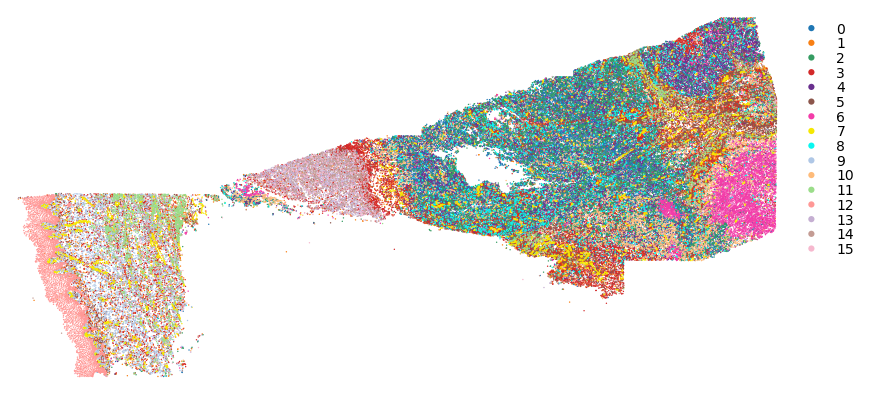

In [12]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)
st.pl.cluster_plot(adata,use_label="louvain",image_alpha=0,size=1)

In [13]:
### Calculating the number of grid spots we will generate
n_ = 125
print(f'{n_} by {n_} has this many spots:\n', n_*n_)

125 by 125 has this many spots:
 15625


In [14]:
### Gridding.
grid = st.tl.cci.grid(adata, n_row=n_, n_col=n_, use_label = 'louvain')
print( grid.shape ) # Slightly less than the above calculation, since we filter out spots with 0 cells.

Gridding...
(6135, 5004)


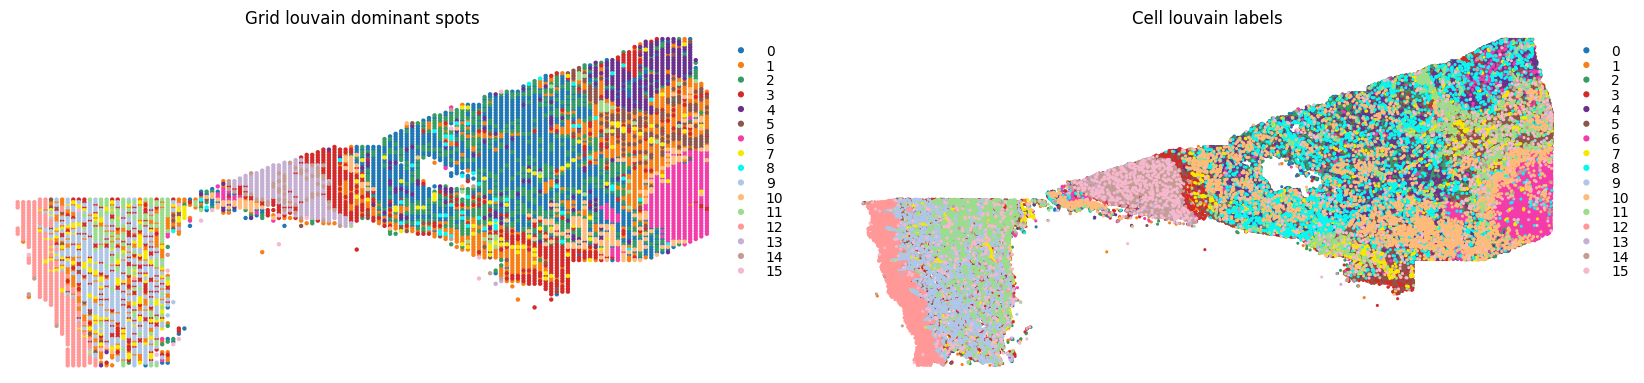

In [17]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, figsize=(20,8))
st.pl.cluster_plot(grid, use_label='louvain', size=10, ax=axes[0], show_plot=False)
st.pl.cluster_plot(adata, use_label='louvain', ax=axes[1], show_plot=False)
axes[0].set_title(f'Grid louvain dominant spots')
axes[1].set_title(f'Cell louvain labels')
plt.show()

In [15]:
# Loading the LR databases available within stlearn (from NATMI)
lrs = st.tl.cci.load_lrs(['connectomeDB2020_lit'], species='human')
print(len(lrs))

2293


In [ ]:
# Running the analysis #
st.tl.cci.run(grid, lrs,
                  min_spots = 20, #Filter out any LR pairs with no scores for less than min_spots
                  distance=0, # None defaults to spot+immediate neighbours; distance=0 for within-spot mode
                  n_pairs=1000, # Number of random pairs to generate; low as example, recommend ~10,000
                  n_cpus=None, # Number of CPUs for parallel. If None, detects & use all available.
                  )

Calculating neighbours...
0 spots with no neighbours, 1 median spot neighbours.
Spot neighbour indices stored in adata.obsm['spot_neighbours'] & adata.obsm['spot_neigh_bcs'].
Altogether 984 valid L-R pairs


Generating backgrounds & testing each LR pair...:  27%|█████████▏                         [ time left: 50:16 ]